In [1]:
import hoomd
import freud
import schmeud
import gsd.hoomd

import matplotlib.pyplot as plt
import numpy as np

import copy
import glob
import pathlib

from monk import prep, methods, pair, render, nb, utils

In [2]:
start_temp = 1.5
temp = 0.05
# S = 1.0
# Sxy = 3e-3

dt = 0.005

In [3]:
outdir = pathlib.Path("/media/ian/Data2/monk/friction-old/")
# outdir = pathlib.Path(".")

In [8]:
rates = np.geomspace(1e-5, 1e-3, 9)
for i in range(10):
    for strain_rate in rates:
        steps = 400_000
        max_strain = 1.0
        strain = strain_rate * steps * dt
        if strain > 0.8:
            steps = int(0.8 / strain_rate / dt)
            strain = strain_rate * steps * dt
            assert strain < max_strain
        elif strain < 0.4:
            steps = int(0.4 / strain_rate / dt)
            strain = strain_rate * steps * dt
            assert strain < max_strain
            strain
        print(i, strain_rate, strain, steps)

        outfile = outdir / f"cs-test-attr_{i}_{strain_rate:.3e}.gsd"
        if outfile.exists():
            print("File exists!")
            continue
        sim = prep.quick_sim(4096, 1.2, hoomd.device.GPU(), dim=2, diams=[1.0, 0.88], ratios=[60, 40], seed=i)
        sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=start_temp)
        integrator = hoomd.md.Integrator(dt=dt)

        nlist = hoomd.md.nlist.Cell(0.3)
        hertz = pair.KA_LJ(nlist)
        # drag = methods.SimpleViscousForce(1.0)
        integrator.forces = [hertz]

        nvt = hoomd.md.methods.NVT(hoomd.filter.All(), kT=start_temp, tau=1.0)
        integrator.methods.append(nvt)

        sim.operations.integrator = integrator
        sim.run(100_000)
        nvt.kT = temp
        sim.run(100_000)
        thermo = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
        logger = hoomd.logging.Logger()
        logger.add(thermo, quantities=["pressure", "pressure_tensor", "kinetic_temperature"])
        sim.operations.computes.clear()
        sim.operations.computes.append(thermo)

        gsd_writer = hoomd.write.GSD(hoomd.trigger.Periodic(1000), outfile, mode="wb", log=logger)
        sim.operations.writers.clear()
        sim.operations.writers.append(gsd_writer)

        sim.operations.updaters.clear()
        trigger = hoomd.trigger.Periodic(1)
        variant = hoomd.variant.Ramp(0, 1, sim.timestep, steps)
        old_box = sim.state.box
        new_box = copy.deepcopy(old_box)
        new_box.xy = strain
        updater = hoomd.update.BoxResize(trigger, old_box, new_box, variant)
        sim.operations.updaters.append(updater)

        # action = methods.KeepBoxTiltsSmall()
        # updater = hoomd.update.CustomUpdater(trigger, action)
        # sim.operations.updaters.append(updater)
        sim.run(steps)

0 1e-05 0.4 8000000
0 1.778279410038923e-05 0.3999999465162202 4498730
0 3.1622776601683795e-05 0.3999999797401245 2529822
0 5.623413251903491e-05 0.39999985153313494 1422623
0 0.0001 0.4 800000
File exists!
0 0.00017782794100389227 0.3999999465162201 449873
File exists!
0 0.00031622776601683794 0.6324555320336759 400000
File exists!
0 0.0005623413251903491 0.7999980160422945 284524
File exists!
0 0.001 0.8 160000
File exists!
1 1e-05 0.4 8000000
1 1.778279410038923e-05 0.3999999465162202 4498730
1 3.1622776601683795e-05 0.3999999797401245 2529822
1 5.623413251903491e-05 0.39999985153313494 1422623
1 0.0001 0.4 800000
File exists!
1 0.00017782794100389227 0.3999999465162201 449873
File exists!
1 0.00031622776601683794 0.6324555320336759 400000
File exists!
1 0.0005623413251903491 0.7999980160422945 284524
File exists!
1 0.001 0.8 160000
File exists!
2 1e-05 0.4 8000000
2 1.778279410038923e-05 0.3999999465162202 4498730
2 3.1622776601683795e-05 0.3999999797401245 2529822
2 5.62341325190

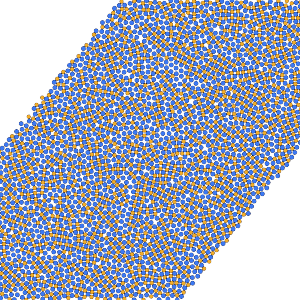

In [19]:
render.render_disk_frame(sim.state.get_snapshot())

In [4]:
files = [f.as_posix() for f in outdir.glob("cs-test-attr_*.gsd")]
p = files[0].find("cs-test-attr_")
file_shear_rates = [float(utils.extract_between(f, f[:p+15], ".gsd")) for f in files]

relate = {k: v for k, v in zip(files, file_shear_rates)}

from collections import defaultdict
res = defaultdict(list)
for key, val in sorted(relate.items()):
    res[val].append(key)

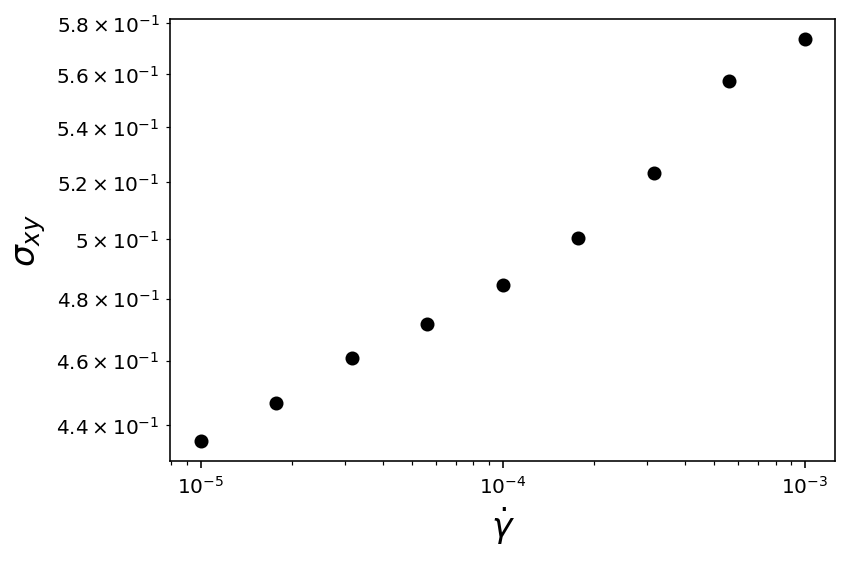

In [5]:
from scipy.ndimage import uniform_filter1d

plt.figure(tight_layout=True)

for s, fs in res.items():
    sigmas = []
    for f in fs:
        traj = gsd.hoomd.open(f, "rb")
        sigma_xy = np.array([snap.log["md/compute/ThermodynamicQuantities/pressure_tensor"][1] for snap in traj])
        sigmas.append(-sigma_xy)
    sigmas = np.mean(sigmas, axis=0)
    xy = np.array([snap.configuration.box[3] for snap in traj])
    # plt.plot(xy, uniform_filter1d(sigmas, 5))
    plt.plot(s, np.mean(sigmas[xy > 0.2]), "ko")
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r"$\sigma_{xy}$", size="xx-large")
plt.xlabel(r"$\dot{\gamma}$", size="xx-large")
plt.savefig("cs-attr_050523_fig1.png")

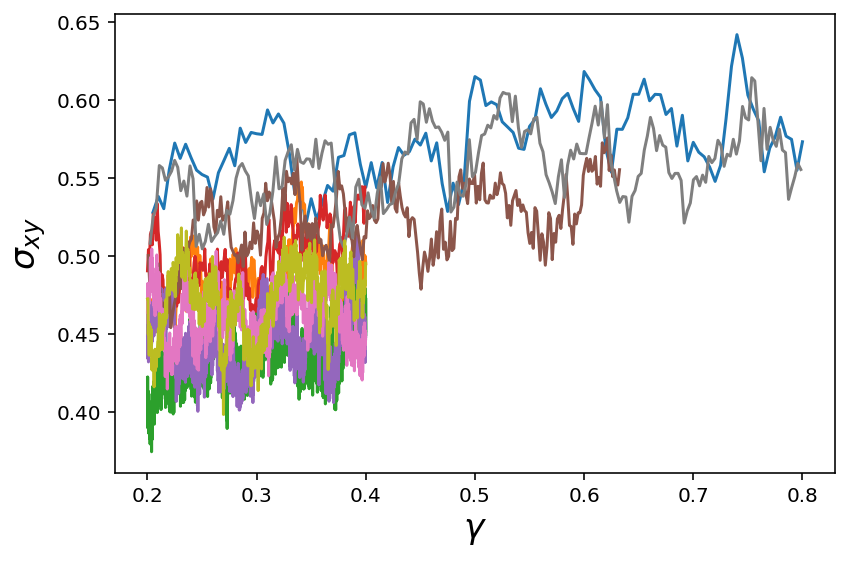

In [6]:
from scipy.ndimage import uniform_filter1d

plt.figure(tight_layout=True)

for s, fs in res.items():
    sigmas = []
    for f in fs:
        traj = gsd.hoomd.open(f, "rb")
        sigma_xy = np.array([snap.log["md/compute/ThermodynamicQuantities/pressure_tensor"][1] for snap in traj])
        sigmas.append(-sigma_xy)
    sigmas = np.mean(sigmas, axis=0)
    xy = np.array([snap.configuration.box[3] for snap in traj])
    # plt.plot(xy, uniform_filter1d(sigmas, 5))
    cond = xy > 0.2
    plt.plot(xy[cond], sigmas[cond])
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel(r"$\sigma_{xy}$", size="xx-large")
plt.xlabel(r"$\gamma$", size="xx-large")
plt.savefig("cs-attr_050523_fig2.png")

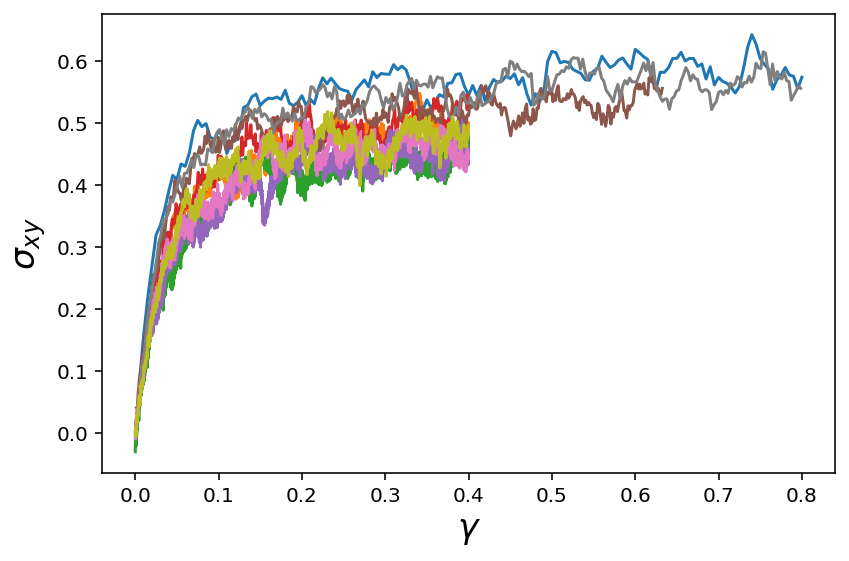

In [7]:
from scipy.ndimage import uniform_filter1d

plt.figure(tight_layout=True)

for s, fs in res.items():
    sigmas = []
    for f in fs:
        traj = gsd.hoomd.open(f, "rb")
        sigma_xy = np.array([snap.log["md/compute/ThermodynamicQuantities/pressure_tensor"][1] for snap in traj])
        sigmas.append(-sigma_xy)
    sigmas = np.mean(sigmas, axis=0)
    xy = np.array([snap.configuration.box[3] for snap in traj])
    # plt.plot(xy, uniform_filter1d(sigmas, 5))
    plt.plot(xy, sigmas)
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel(r"$\sigma_{xy}$", size="xx-large")
plt.xlabel(r"$\gamma$", size="xx-large")
plt.savefig("cs-attr_050523_fig3.png")